In [1]:
!pip install --quiet --upgrade tensorflow-federated
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-build-IcC6ki/tensorflow-privacy/
Exception:
Traceback (most recent call last):
  File "/usr/lib/python2.7/site-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/usr/lib/python2.7/site-packages/pip/commands/install.py", line 326, in run
    strip_file_prefix=options.strip_file_prefix,
  File "/usr/lib/python2.7/site-packages/pip/req/req_set.py", line 742, in install
    **kwargs
  File "/usr/lib/python2.7/site-packages/pip/req/req_install.py", line 834, in install
    strip_file_prefix=strip_file_prefix
  File "/usr/lib/python2.7/site-packages/pip/req/req_install.py", line 1037, in move_wheel_files
    strip_file_prefix=strip_file_prefix,
  File "/usr/lib/python2.7/site-packages/pip/wheel.py", line 346, in move_wheel_files
    clobber(source, lib_dir, True)
  File "/usr/lib/python2.7/site-packages/pip/wheel.py", line 317, in clobber
    ensure_dir(destdir)
  File "/usr/lib

In [ ]:
# Original implementation from
# https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_2

In [188]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split

# Must use the Python context because it
# supports tff.sequence_* intrinsics.
executor_factory = tff.framework.local_executor_factory(
    support_sequence_ops=True)
execution_context = tff.framework.ExecutionContext(
    executor_fn=executor_factory)
tff.framework.set_default_context(execution_context)

In [189]:
# Ensure TFF is functional
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

b'Hello, World!'

In [197]:
# Load in fashion MNIST
mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()

In [198]:
mnist_test[0].shape

(10000, 28, 28)

In [201]:
# Perform validation split
X_train, X_test, y_train, y_test = train_test_split(
...     mnist_train[0], mnist_train[1], test_size=0.166666666, random_state=42)

In [203]:
X_train.shape

(50000, 28, 28)

In [205]:
mnist_train = (X_train, y_train)

In [206]:
mnist_val = (X_test, y_test)

In [149]:
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

In [207]:
# Created federated data
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100


def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x':
            np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                     dtype=np.float32),
        'y':
            np.array([source[1][i] for i in batch_samples], dtype=np.int32)
    })
  return output_sequence


federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]
federated_val_data = [get_data_for_digit(mnist_val, d) for d in range(10)]
federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

In [208]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

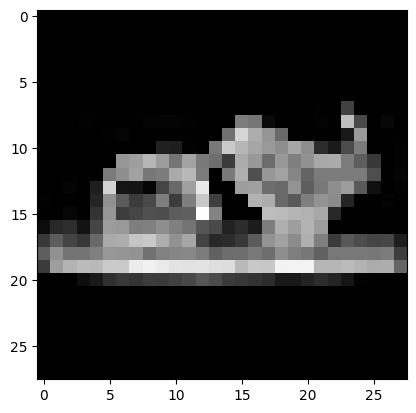

In [209]:
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')
plt.grid(False)
plt.show()

In [210]:
# Defining input type
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

In [211]:
# Model parameters (784 -> 10)
MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[10], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)
print(MODEL_TYPE)

<weights=float32[784,10],bias=float32[10]>


In [212]:
# Define loss function

# NOTE: `forward_pass` is defined separately from `batch_loss` so that it can 
# be later called from within another tf.function. Necessary because a
# @tf.function  decorated method cannot invoke a @tff.tf_computation.

@tf.function
def forward_pass(model, batch):
  predicted_y = tf.nn.softmax(
      tf.matmul(batch['x'], model['weights']) + model['bias'])
  return -tf.reduce_mean(
      tf.reduce_sum(
          tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
# Perform loss over one batch
def batch_loss(model, batch):
  return forward_pass(model, batch)

In [213]:
str(batch_loss.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>> -> float32)'

In [214]:
initial_model = collections.OrderedDict(
    weights=np.zeros([784, 10], dtype=np.float32),
    bias=np.zeros([10], dtype=np.float32))

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)

2.3025851

In [215]:
# Perform gradient descent on one batch
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  # Define a group of model variables and set them to `initial_model`. Must
  # be defined outside the @tf.function.
  model_vars = collections.OrderedDict([
      (name, tf.Variable(name=name, initial_value=value))
      for name, value in initial_model.items()
  ])
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  @tf.function
  def _train_on_batch(model_vars, batch):
    # Perform one step of gradient descent using loss from `batch_loss`.
    with tf.GradientTape() as tape:
      loss = forward_pass(model_vars, batch)
    grads = tape.gradient(loss, model_vars)
    optimizer.apply_gradients(
        zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
    return model_vars

  return _train_on_batch(model_vars, batch)

In [216]:
str(batch_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>,learning_rate=float32> -> <weights=float32[784,10],bias=float32[10]>)'

In [217]:
# Check if loss decreases
model = initial_model
losses = []
for _ in range(5):
  model = batch_train(model, sample_batch, 0.1)
  losses.append(batch_loss(model, sample_batch))

In [218]:
losses

[0.5511293, 0.30036294, 0.2142646, 0.16859454, 0.13981651]

In [219]:
# Perform gradient descent on local data sequence
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):

  @tff.tf_computation(LOCAL_DATA_TYPE, tf.float32)
  def _insert_learning_rate_to_sequence(dataset, learning_rate):
    return dataset.map(lambda x: (x, learning_rate))

  batches_with_learning_rate = _insert_learning_rate_to_sequence(all_batches, learning_rate)

  # Mapping function to apply to each batch.
  @tff.federated_computation(MODEL_TYPE, batches_with_learning_rate.type_signature.element)
  def batch_fn(model, batch_with_lr):
    batch, lr = batch_with_lr
    return batch_train(model, batch, lr)

  return tff.sequence_reduce(batches_with_learning_rate, initial_model, batch_fn)

In [220]:
str(local_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,learning_rate=float32,all_batches=<x=float32[?,784],y=int32[?]>*> -> <weights=float32[784,10],bias=float32[10]>)'

In [221]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])

In [235]:
# Local evaluation: add losses across all batches
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):

  @tff.tf_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
  def _insert_model_to_sequence(model, dataset):
    return dataset.map(lambda x: (model, x))

  model_plus_data = _insert_model_to_sequence(model, all_batches)

  @tff.tf_computation(tf.float32, batch_loss.type_signature.result)
  def tff_add(accumulator, arg):
    return accumulator + arg

  return tff.sequence_reduce(
      tff.sequence_map(
          batch_loss,
          model_plus_data), 0., tff_add)

In [223]:
str(local_eval.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,all_batches=<x=float32[?,784],y=int32[?]>*> -> float32)'

In [224]:
# Trained well on one
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[5]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[5]))

initial_model loss = 23.025854
locally_trained_model loss = 0.80498904


In [225]:
# but not the other
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[0]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[0]))

initial_model loss = 23.025854
locally_trained_model loss = 81.17179


In [226]:
SERVER_MODEL_TYPE = tff.type_at_server(MODEL_TYPE)
CLIENT_DATA_TYPE = tff.type_at_clients(LOCAL_DATA_TYPE)

In [227]:
# Perform federated evaluation
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
  return tff.federated_mean(
      tff.federated_map(local_eval, [tff.federated_broadcast(model),  data]))

In [228]:
print('initial_model loss =', federated_eval(initial_model,
                                             federated_train_data))
print('locally_trained_model loss =',
      federated_eval(locally_trained_model, federated_train_data))

initial_model loss = 23.025852
locally_trained_model loss = 84.29628


In [229]:
# Federated training
SERVER_FLOAT_TYPE = tff.type_at_server(tf.float32)


@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  # Perform federated averaging here
  return tff.federated_mean(
      tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data
      ]))

In [230]:
# Training loop
model = initial_model
learning_rate = 0.1
losses = []
lossesVal = []
for round_num in range(30):
  model = federated_train(model, learning_rate, federated_train_data)
  learning_rate = learning_rate * 0.9
  loss = federated_eval(model, federated_train_data)
  losses.append(loss)
  lossVal = federated_eval(model, federated_val_data)
  lossesVal.append(lossVal)
  print('round {}, loss={}'.format(round_num, loss))

round 0, loss=20.717805862426758
round 1, loss=19.1876277923584
round 2, loss=18.006128311157227
round 3, loss=17.077972412109375
round 4, loss=16.330320358276367
round 5, loss=15.714973449707031
round 6, loss=15.19837474822998
round 7, loss=14.756823539733887
round 8, loss=14.373250007629395
round 9, loss=14.035194396972656
round 10, loss=13.733485221862793
round 11, loss=13.4613676071167
round 12, loss=13.213876724243164
round 13, loss=12.987370491027832
round 14, loss=12.779170989990234
round 15, loss=12.58726692199707
round 16, loss=12.410087585449219
round 17, loss=12.246368408203125
round 18, loss=12.095026969909668
round 19, loss=11.95511531829834
round 20, loss=11.825779914855957
round 21, loss=11.706245422363281
round 22, loss=11.595793724060059
round 23, loss=11.49377155303955
round 24, loss=11.399569511413574
round 25, loss=11.31263256072998
round 26, loss=11.232446670532227
round 27, loss=11.158539772033691
round 28, loss=11.090472221374512
round 29, loss=11.027838706970215

In [231]:
# Final model
print('initial_model test loss =',
      federated_eval(initial_model, federated_test_data))
print('trained_model test loss =', federated_eval(model, federated_test_data))

initial_model test loss = 23.025852
trained_model test loss = 11.182663


In [232]:
import matplotlib.pyplot as plt

In [233]:
epochs = list(range(30))
epochs

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

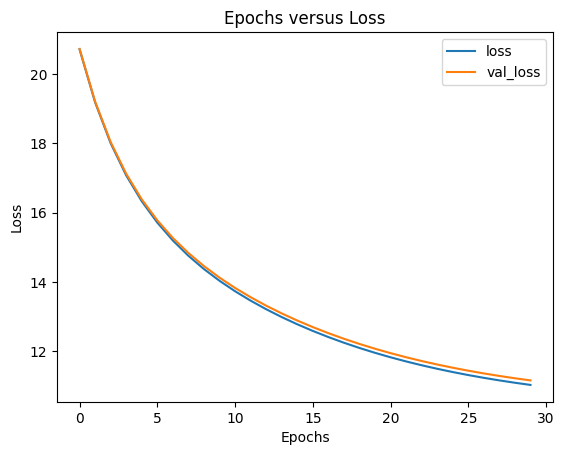

In [236]:
# Plot loss and validation loss
plt.plot(epochs, losses, label = 'loss')
plt.plot(epochs, lossesVal, label = 'val_loss')
plt.title("Epochs versus Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [238]:
lossesVal[0]

20.730726

In [239]:
lossesVal[-1]

11.158117